# AIRS channel selection

Calculate trends for each AIRS channel.

Create infrastructure for easy spatial correlations between AIRS trends and other variables (to select representative channels). This will require a flexible/intelligent interpolation choice.

Consider doing correlations between variables/obs instead of trends (more robust likely).

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [2]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [3]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [12]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
        print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Create AIRS spectral trends file

In [5]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
# airs_files = glob.glob('%s/L3OLR/**.nc' % airs_dir)
airs_files = glob.glob('%s/proc/**.nc' % airs_dir)

airs_files.sort()
# ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

Open all files together.

In [6]:
all_airs = xr.open_mfdataset(airs_files,
                             parallel=True)

Take even years 2003-2018 (16 total).

Select the Arctic, and weight the ascending and descending orbits equally.

#### These calculation required ~3 gb of memory (I ran with 4)

In [71]:
if not os.path.exists('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/')):
    
    # Subset for efficiency
    olr_subset = all_airs['olr_spectral'].sel(lat=slice(59,None),time=slice('2003-01-01','2018-12-31')).mean(dim='orbit_pass')
    
    # Calculate trends after averaging over longitudes
    _trends_spec_olr,_statsig_spec_olr,_notnull_spec_olr = compute_trends_n_signif2(olr_subset.mean(dim='lon'))
    
    # Combine into a single file and save
    all_data_spec_olr = xr.merge([_trends_spec_olr.rename('TREND'),_statsig_spec_olr.rename('STATSIG'),_notnull_spec_olr.rename('NOTNULL')])
    all_data_spec_olr.to_netcdf('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))    

In [ ]:
if not os.path.exists('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/')):
    # Subset for efficiency
    olr_clr_subset = all_airs['olr_clr_spectral'].sel(lat=slice(59,None),time=slice('2003-01-01','2018-12-31')).mean(dim='orbit_pass')

    # Calculate trends after averaging over longitudes
    _trends_spec_olr_clr,_statsig_spec_olr_clr,_notnull_spec_olr_clr = compute_trends_n_signif2(olr_clr_subset.mean(dim='lon'))
    
    # Combine into a single file and save
    all_data_spec_olr_clr = xr.merge([_trends_clr.rename('TREND'),_statsig_clr.rename('STATSIG'),_notnull_clr.rename('NOTNULL')])
    all_data_spec_olr_clr.to_netcdf('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

#### Correlate individual channels

This is a first step before correlating spectral channels (trends) with observations (trends)

Create masked arrays (either using a where statement or the numpy.ma subpackage.

In [138]:
def calculate_spatial_correlation(cntl,test):
    """
    Calculate the spatial correlation coefficient for two xarray dataarrays, weighting by gridcell area.
    Values marked with a Nan are mutually masked.
    """
    
    _cntl = add_weights(cntl)
       
    mask = np.bitwise_or(xr.ufuncs.isnan(cntl),xr.ufuncs.isnan(test)) # mask means hide
    
    wgt = np.array(_cntl['cell_weight'])
    wgt = np.where(~mask,wgt,np.nan) # erroring
    
    sumwgt = np.nansum(wgt)
        
    # calculate means
    meantest = np.nansum(wgt*test)/sumwgt
    meancntl = np.nansum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.nansum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.nansum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.nansum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem
    
    return corr

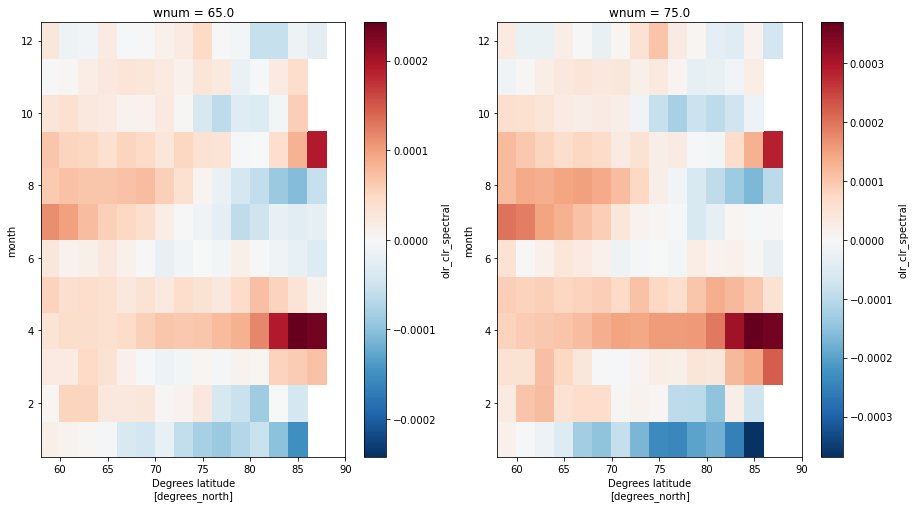

In [200]:
fig_t,axs_t = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

_trends_clr[:,5,:].plot(ax=axs_t[0])
_trends_clr[:,6,:].plot(ax=axs_t[1])

In [201]:
calculate_spatial_correlation(_trends_clr[:,5,:],_trends_clr[:,6,:])

0.9521779096529754

In [202]:
calculate_spatial_correlation(_trends_clr[:,6,:],_trends_clr[:,6,:])

1.0000000261391122

This all looks good. There seems to be a small rounding error somewhere in the code, but it is less than a part in a million.

## Test spatial correlations with GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [203]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [204]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [205]:
giss_tsel = giss1.sel(time=slice('2001-01','2020-12'))['air']

In [206]:
giss1.close()

#### Temperature from GISStemp

In [207]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [208]:
gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif2(gisstemp_subset)

123456789101112

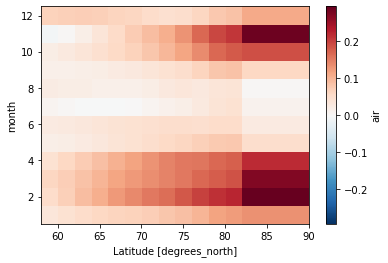

In [210]:
gisstemp_trends.plot()

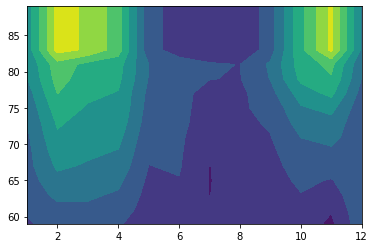

In [213]:
plt.contourf(gisstemp_trends['month'],gisstemp_trends['lat'],gisstemp_trends.transpose('lat','month'))

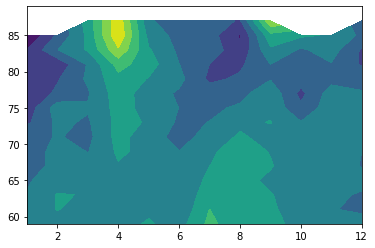

In [224]:
plt.contourf(_trends_clr['month'],_trends_clr['lat'],_trends_clr[:,5,:].transpose('lat','month'))

In [221]:
gisstemp_interpd = gisstemp_trends.interp_like(_trends_clr)

In [227]:
trends_reorg = _trends_clr.transpose('wnum','month','lat')

In [246]:
rvals = {}
rvals_list =[]

for _wnum in trends_reorg:
    
    r = calculate_spatial_correlation(_wnum,gisstemp_interpd)
    
    rvals[str(_wnum.wnum.values)] = r
    rvals_list.append(r)
#     print(r)
    
#     break

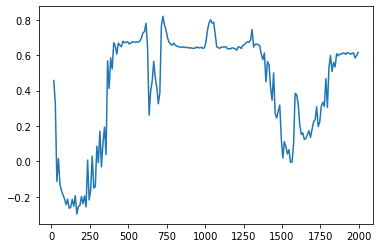

In [247]:
plt.plot(trends_reorg.wnum,np.array(rvals_list))